***
## <font color=red>Anomaly/Outlier Detection Model with PyOD </font>
<p style="margin-left:3%; margin-right:10%;"><font color=teal> L. Saetta   07/2021</font></p>

* modified: 01/10/2021

* This model uses: IForest

***

In [1]:
import os
import pandas as pd
import numpy as np
from sklearn import preprocessing
import seaborn as sns
import matplotlib.pyplot as plt
from pyod.models.iforest import IForest

sns.set(color_codes=True)
%matplotlib inline

In [2]:
# globals
FIGSIZE = (12,8)

### Step 2: load from the single datafile

In [3]:
RESULT_FILE_NAME = "BearingsNasaTest1.csv"

result_data = pd.read_csv(RESULT_FILE_NAME, index_col = 0)

# attenzione, il formato della data è cambiato
result_data.index = pd.to_datetime(result_data.index, format='%Y-%m-%d %H:%M:%S')
result_data = result_data.sort_index()

In [4]:
result_data.head()

,Br11,Br12,Br21,Br22,Br31,Br32,Br41,Br42
2003-10-22 12:06:24,0.1041,0.1003,0.1071,0.1020,0.1061,0.1082,0.0948,0.0995
2003-10-22 12:09:13,0.1037,0.0999,0.1082,0.1029,0.1067,0.1085,0.0951,0.0936
2003-10-22 12:14:13,0.1050,0.1015,0.1085,0.1040,0.1087,0.1099,0.0962,0.0983
2003-10-22 12:19:13,0.1049,0.1016,0.1082,0.1034,0.1081,0.1100,0.0968,0.0986
2003-10-22 12:24:13,0.1048,0.1022,0.1079,0.1026,0.1085,0.1093,0.0964,0.0985


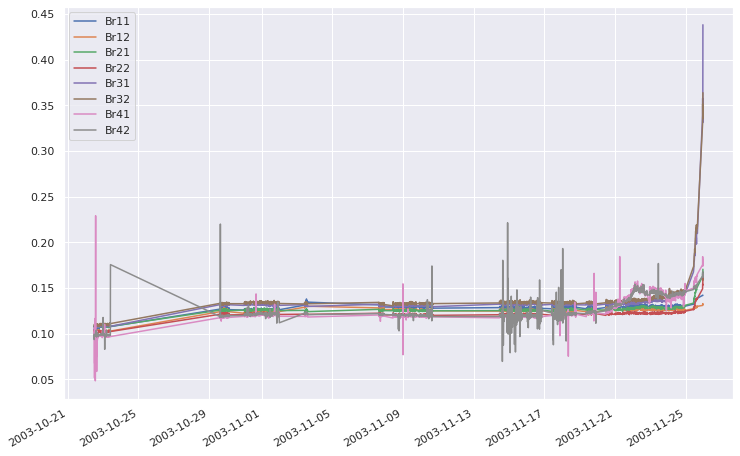

In [6]:
# plot all data
result_data.plot(figsize = FIGSIZE);

<AxesSubplot:>

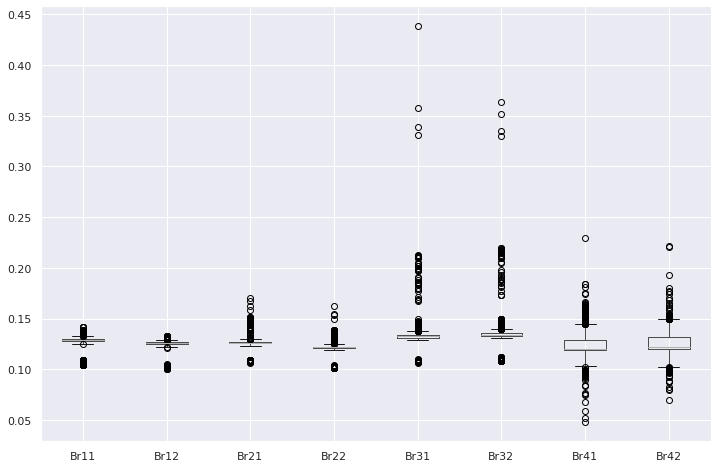

In [7]:
plt.figure(figsize = FIGSIZE)

result_data.boxplot()

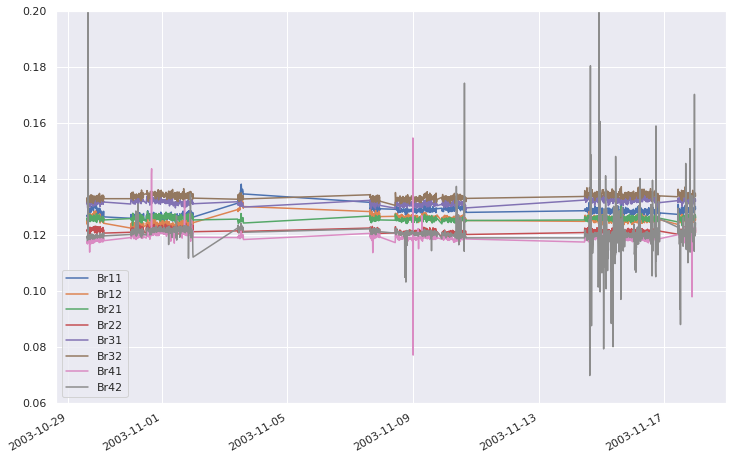

In [8]:
# prendo prima parte dati come train !!!
# data from the first interval used for training
START_TIME = '2003-10-25 00:00:01'
SPLIT_TIME = '2003-11-17 23:59:00'

# before the SPLIT_TIME
dataset_train = result_data[START_TIME:SPLIT_TIME]

dataset_test = result_data[SPLIT_TIME:]

# vibrazioni normali
dataset_train.plot(figsize = FIGSIZE, ylim = (0.06, 0.2));

In [9]:
# come si vede da un certo punto le vibrazioni aumentano 
# e quelle di un cuscinetto "esplodono"
# dataset_test.plot(figsize = FIGSIZE);

In [10]:
# porto le feature sulla stessa scala...
scaler = preprocessing.MinMaxScaler()

# ovviamente lo scaler è addestrato soltanto sul training test
X_train = pd.DataFrame(scaler.fit_transform(dataset_train), columns = dataset_train.columns, 
                       index = dataset_train.index)

# e lo stesso scaler è usato sul test set (non si devono contaminare)
X_test = pd.DataFrame(scaler.transform(dataset_test), columns = dataset_test.columns, 
                      index = dataset_test.index)

* fin qui nulla di nuovo rispetto ad AutoEncoder

### PyOD
* usiamo **IsolationForest**

In [11]:
# in questo caso dobbiamo specificare la percentuale attesa di anomalie nel campione
clf1 = IForest(behaviour="new", max_samples=1200, contamination=0.01)

In [12]:
%%time

clf1.fit(np.array(X_train))

/home/datascience/conda/tensorflow23_p37_gpu_v1/lib/python3.7/site-packages/sklearn/ensemble/_iforest.py:288: UserWarning: max_samples (1200) is greater than the total number of samples (1163). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))


CPU times: user 433 ms, sys: 1.83 ms, total: 435 ms
Wall time: 443 ms


IForest(behaviour='new', bootstrap=False, contamination=0.01,
    max_features=1.0, max_samples=1200, n_estimators=100, n_jobs=1,
    random_state=None, verbose=0)

In [13]:
od_train_scores = clf1.decision_function(np.array(X_train))  # outlier scores

od_train_scores = pd.DataFrame(od_train_scores, index = X_train.index, columns = ['OUTSCORE'])

/home/datascience/conda/tensorflow23_p37_gpu_v1/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


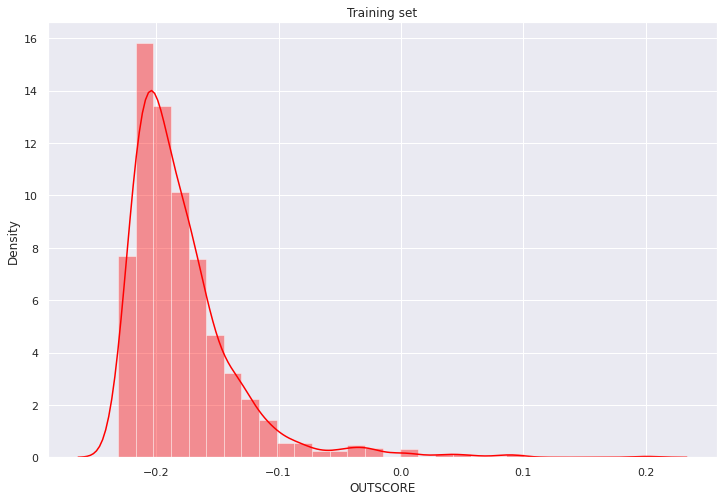

In [14]:
plt.figure(figsize = FIGSIZE)

# disegno istogramma
plt.title('Training set')
sns.distplot(od_train_scores['OUTSCORE'], bins = 30, kde= True, color = 'red');

In [15]:
# guardando ai due istogrammi
# we can choose 0 as THRESHOLD

In [16]:
od_test_scores = clf1.decision_function(np.array(X_test))  # outlier scores

od_test_scores = pd.DataFrame(od_test_scores, index = X_test.index, columns = ['OUTSCORE'])

/home/datascience/conda/tensorflow23_p37_gpu_v1/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


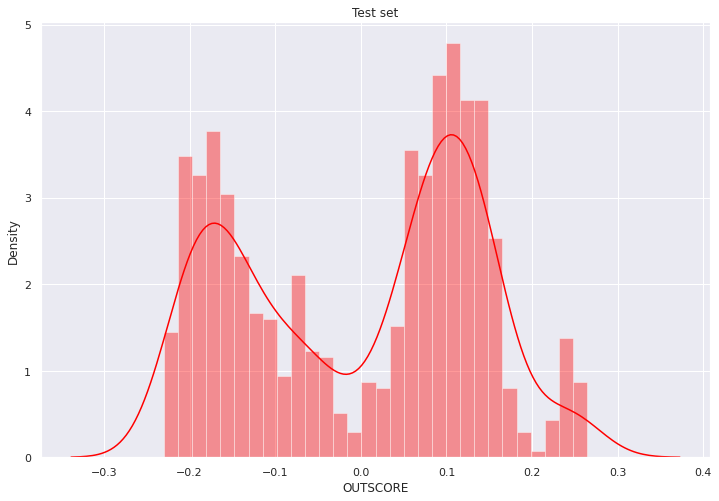

In [17]:
plt.figure(figsize = FIGSIZE)

# disegno istogramma
plt.title('Test set')
sns.distplot(od_test_scores['OUTSCORE'], bins = 30, kde= True, color = 'red');

In [18]:
THR = 0.
# prendiamo come soglia 0. (vedi grafico precedente)

od_test_scores['THR'] = THR
od_test_scores['Anomaly'] = od_test_scores['OUTSCORE'] > od_test_scores['THR']

od_test_scores.tail()

,OUTSCORE,THR,Anomaly
2003-11-25 16:07:32,0.255694,0.0,True
2003-11-25 23:13:21,0.259988,0.0,True
2003-11-25 23:19:56,0.259557,0.0,True
2003-11-25 23:29:56,0.264304,0.0,True
2003-11-25 23:39:56,0.260418,0.0,True


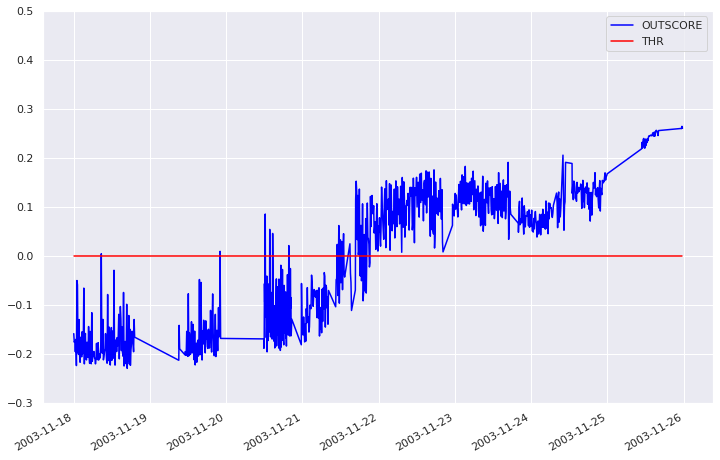

In [19]:
od_test_scores.plot(logy=False,  figsize = FIGSIZE, ylim = [-0.3, 0.5], color = ['blue','red']);

### Anche qui riusciamo a prevedere il fault con più di 4 gg di anticipo

### How many alerts per day ?

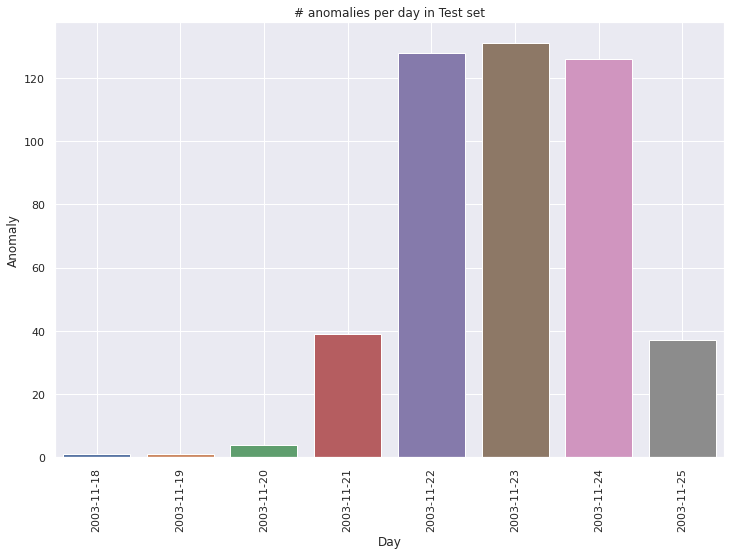

In [20]:
def extract_date(x):
    return str(pd.to_datetime(x).date())

# extract day
od_test_scores['Day'] = od_test_scores.index
od_test_scores['Day'] = od_test_scores['Day'].apply(extract_date)

vet_x = od_test_scores.groupby(['Day']).sum().index
vet_y = od_test_scores.groupby(['Day']).sum()['Anomaly']

plt.figure(figsize=FIGSIZE)
plt.title('# anomalies per day in Test set')
sns.barplot(x=vet_x, y=vet_y)

plt.xticks(rotation=90)
plt.grid(True)

PyOD isolation forest predict anomalies also on 20-11, a day before Keras custom AutoEncoder.